In [2]:
!python -m spacy download pt_core_news_sm
!pip -q install transformers
# !pip install selenium
# !apt-get update # to update ubuntu to correctly run apt install
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=9c32cbfe1abd2bb78344c68480ae4d49df52cc4ca14ccb79e2130584f93d4715
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfd382ta/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
     |████████████████████████████████| 2.6 MB 8.2 MB/s 
     |████████████████████████████████| 636 kB 67.8 MB/s 
     |████████████████████████████████| 3.3 MB 42.5 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 


In [3]:
from transformers import BertForTokenClassification, DistilBertTokenizerFast, pipeline
from urllib.request import urlopen
from lxml import etree
import re
import nltk
from bs4 import BeautifulSoup
import requests
import string
import unicodedata
#from selenium import webdriver
#from selenium.webdriver.chrome.options import Options
import time
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

import pt_core_news_sm
pos_tagger = pt_core_news_sm.load()

nltk.download('punkt')
sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle').tokenize

model = BertForTokenClassification.from_pretrained('monilouise/ner_pt_br')
tokenizer = DistilBertTokenizerFast.from_pretrained('neuralmind/bert-base-portuguese-cased', 
                                                    model_max_length=512,
                                                    do_lower_case=False)
NER = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/token_classification.py:155: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  f'`grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="{aggregation_strategy}"` instead.'


In [5]:
def limpar_texto(texto):
    # Se vazio, retorna
    if texto is None or len(texto.strip()) == 0:
        return texto

        # Remover acentos
        result = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')

        # Remover caracteres especiais
        lista = '-#?º°ª.:/;~^`[{]}\\|!$%"\'&*()=+,><\t\r\n…'
        for i in range(0, len(lista)):
            result = result.replace(lista[i], ' ')

        # Transformar multiplos espacos em apenas um
        result = re.sub(' +', ' ', result)

        # Transformar em LOWER case
        result = result.lower()

        return result

# Obter notícias de Política

### Carregar via requisicao

In [6]:
url =  "https://noticias.uol.com.br/politica/"
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html)
elemento_titulo = soup.find_all("h3", {"class": "title-lg-small"})
len(elemento_titulo)

47

### Carregar clicando em VER MAIS

In [11]:
# Chrome
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # Não abrir o navegador: fazer operações no background
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver', options=chrome_options)

url = 'https://noticias.uol.com.br/politica/'

driver.get(url)
for _ in range(5):
    # Achar botao de VER MAIS
    element = driver.find_element_by_css_selector('button[class*="btn-primary"]')
    # Clicar no botao de VER MAIS
    driver.execute_script("arguments[0].click();", element)
    # Aguardar carregar por 1 seg
    time.sleep(1)

# Selecionar a secao com todas as noticias carregadas
element = driver.find_element_by_css_selector('section[class*="collection-index"]')
html = element.get_attribute('outerHTML')
driver.quit()

soup = BeautifulSoup(html, 'lxml')

# Pegar titulos
elemento_titulo = soup.find_all("h3", {"class": "title-lg-small"})
len(elemento_titulo)

282

In [7]:
elemento_titulo[:10]

[<h3 class="thumb-title title-xsmall title-lg-small">Gilmar Mendes rechaça argumentos por voto impresso: 'Conversa fiada'</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Com live, Bolsonaro quis motivar militância desanimada com Centrão</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Inquérito apura se Wassef mantinha escritório de fachada em SP, diz TV</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Bolsonaro diz que vai manter auxílio emergencial se pandemia continuar</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Sakamoto: live de Bolsonaro foi 'maior metralhadora de mentiras por minuto'</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Incêndio da Cinemateca não é acidente, mas resultado de um projeto de país</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Ciro Gomes critica Bolsonaro por falas de fraude eleitoral: 'mentiroso mor'</h3>,
 <h3 class="thumb-title title-xsmall title-lg-small">Diretor da Fundação FHC defen

### Obter links

In [8]:
noticias_links = []
for noticia in elemento_titulo:
    # Subir pai duas vezes para pegar link
    noticia_url = noticia.parent.parent['href']
    if "/colunas/" not in noticia_url and "/videos/" not in noticia_url:
        noticias_links.append([noticia_url, noticia.text])

In [9]:
len(noticias_links), noticias_links[0]

(27,
 ['https://noticias.uol.com.br/politica/ultimas-noticias/2021/07/30/arthur-lira-camara-gilmar-mendes-stf-debate.htm',
  "Gilmar Mendes rechaça argumentos por voto impresso: 'Conversa fiada'"])

### Ler cada noticia e quebrar sentencas

In [10]:
def obter_sentencas_da_pagina(url):
    response = requests.get(url)
    html = response.text

    soup = BeautifulSoup(html)
    divs_texto = soup.find_all("div", {"class": "text"})
  
    sentencas = []
    for div in divs_texto:
        paragrafos = div.find_all("p")
        for t in paragrafos:
            sentencas.extend(sent_tokenizer(t.text)) # Tokenizar sentencas
  
    return sentencas

In [11]:
noticias_politica = []

for url, titulo in tqdm(noticias_links):
    noticias_politica.append( [url, titulo, obter_sentencas_da_pagina(url)] )

100%|██████████| 27/27 [00:32<00:00,  1.19s/it]


In [12]:
noticias_politica[0]

['https://noticias.uol.com.br/politica/ultimas-noticias/2021/07/30/arthur-lira-camara-gilmar-mendes-stf-debate.htm',
 "Gilmar Mendes rechaça argumentos por voto impresso: 'Conversa fiada'",
 ['O ministro do STF (Supremo Tribunal Federal) Gilmar Mendes criticou hoje os argumentos do presidente Jair Bolsonaro (sem partido) e dos apoiadores do governo para defender um voto impresso.',
  'Para o magistrado, a discussão sobre a necessidade ou não do voto impresso soa como uma "falsa questão" a ser debatida.',
  '"Vamos parar um pouco de conversa fiada", disse, em participação em debate ao lado do presidente da Câmara, deputado federal Arthur Lira (PP-AL).',
  '"Essa ideia de que, sem voto impresso, não podemos ter eleições ou não vamos ter eleições confiáveis, na verdade, esconde talvez algum tipo de intenção subjacente, de uma intenção que não é boa", afirmou.',
  'No debate, Gilmar ainda disse que, se há tanta desconfiança com as urnas eletrônicas, os defensores do voto impresso deveriam 

# NER

In [13]:
def reconhecer_entidades(sentenca):

    # NER com entidades tokenizdas
    lista_entidades = NER(sentenca)

    prev_end = -1
    prev_type = ""
    curr_ent = ""
    start = 0

    lista_atual_ent = []

    for ent in lista_entidades:
        if ent['start'] - prev_end <= 2 and ent['entity_group'] == prev_type:
            if ent['word'].startswith("##"):
                curr_ent += ent['word'][2:]
            else:
                curr_ent += " " + ent['word']
        else:
            if curr_ent != "":
                lista_atual_ent.append((curr_ent, prev_type, start, prev_end))
            curr_ent = ent['word']
            start = ent['start']
    
        prev_type = ent['entity_group']
        prev_end = ent['end']

    if curr_ent != "":
        lista_atual_ent.append((curr_ent, prev_type, start, prev_end))

    return lista_atual_ent

In [14]:
ex_noticia = noticias_politica[0]
lista_sentencas = ex_noticia[2]
lista_entidades = [reconhecer_entidades(sentenca) for sentenca in lista_sentencas]
lista_entidades

[[('STF Supremo Tribunal Federal', 'PUB', 14, 43),
  ('Gilmar Mendes', 'PESSOA', 45, 58),
  ('Jair Bolsonaro', 'PESSOA', 101, 115)],
 [],
 [('Câmara', 'PUB', 100, 106), ('Arthur Lira', 'PESSOA', 125, 136)],
 [],
 [('Gilmar', 'PESSOA', 11, 17)],
 [],
 []]

In [15]:
indice = 0
texto_noticia = lista_sentencas[indice]
entidades_noticia = [ent for ent in lista_entidades[indice] if ent[1] in ['ORG', 'PESSOA', 'PUB']]
texto_noticia, entidades_noticia

('O ministro do STF (Supremo Tribunal Federal) Gilmar Mendes criticou hoje os argumentos do presidente Jair Bolsonaro (sem partido) e dos apoiadores do governo para defender um voto impresso.',
 [('STF Supremo Tribunal Federal', 'PUB', 14, 43),
  ('Gilmar Mendes', 'PESSOA', 45, 58),
  ('Jair Bolsonaro', 'PESSOA', 101, 115)])

# Destaques no texto

In [21]:
from IPython.display import HTML as html_print

def highlight_ent_verbo(sentenca, entidades, destaque):
    if len(entidades) <= 1:
        return

    texto_color = " - "
    def colorir(x, cor='blue'):
        if is_destaque and cor=='red':
            return "<span style='color:" + cor + "; background-color:yellow'>" + x + "</span>"
        else:
            return "<span style='color:" + cor + "'>" + x + "</span>"

    prev_ind = 0
    for ent in entidades:
        is_destaque = False
        if ent[0] == destaque:
            is_destaque = True

        # Texto ate proxima entidade
        texto_ate_prox = sentenca[prev_ind:ent[2]]
        tokens_pos = pos_tagger(texto_ate_prox)
        texto_proc = ""
        for token in tokens_pos:
            if token.pos_ == 'VERB':
                texto_proc += colorir(token.text) + " "
        
            elif token.sentiment > 0:
                texto_proc += colorir(token.text, 'yellow') + " "
            else:
                texto_proc += token.text + " "

    texto_color += texto_proc
    texto_color += colorir(sentenca[ent[2]:ent[3]], 'red')
    prev_ind = ent[3]


    texto_ate_prox = sentenca[prev_ind:]
    tokens_pos = pos_tagger(texto_ate_prox)
    texto_proc = ""
    for token in tokens_pos:
        if token.pos_ == 'VERB':
            texto_proc += colorir(token.text) + " "
        else:
            texto_proc += token.text + " "
  
    texto_color += texto_proc

    display(html_print(texto_color))


In [25]:
ex_sentenca = "Manoel Joaquim acusou Maria Silva, do Ministerio dos Repasses, de conluio com diversas empresas."
ex_entidades = reconhecer_entidades(ex_sentenca)
ex_destaque = "Maria Silva"
highlight_ent_verbo(ex_sentenca, ex_entidades, ex_destaque)

# WordCloud

In [45]:
corpus = []
for noticia in noticias_politica:
    corpus.append(" ".join(noticia[2]))

In [46]:
vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('portuguese'), use_idf=True)
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
df = pd.DataFrame(vecs.todense().tolist(), columns=feature_names)

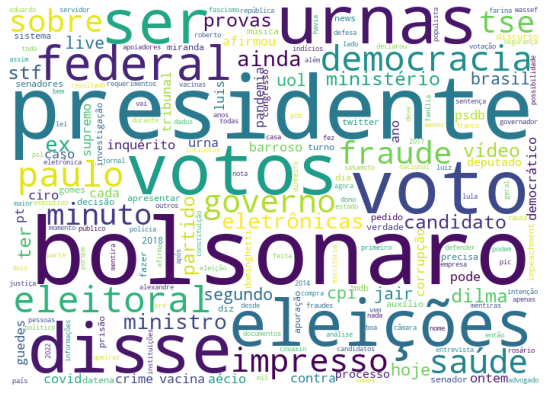

In [63]:
wordcloud = WordCloud(width=700, height=500, background_color='white').generate_from_frequencies(df.T.sum(axis=1))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

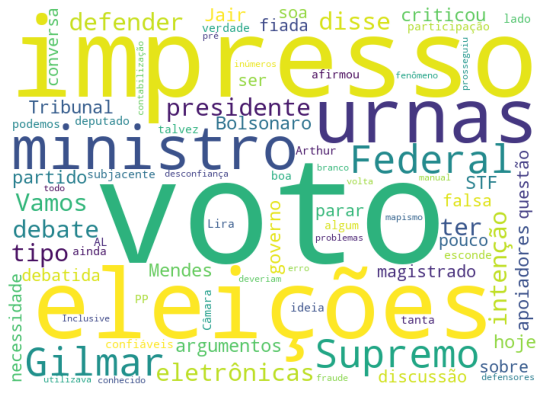

In [66]:
wordcloud = WordCloud(width = 700, height = 500, background_color='white', stopwords=nltk.corpus.stopwords.words('portuguese')).generate(corpus[0])
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud) 
plt.axis("off");

# Monitorar noticias

- A ideia é Monitorar pessoas.
- Caso apareça uma que não havia aparecido antes, informar as notícias e destacar trechos.

### Definir noticias processadas

In [74]:
todas_pessoas = []
todas_noticias = []

In [75]:
for noticia in tqdm(noticias_politica[2:], position=0, leave=True):
    link = noticia[0]
    lista_sentencas = noticia[2]
    for sentenca in lista_sentencas:
        lista_ent = reconhecer_entidades(sentenca)
        for ent in lista_ent:
            if ent[1] == 'PESSOA':
                todas_pessoas.append(ent[0])
    todas_noticias.append(link)

len(todas_pessoas), len(todas_noticias)

100%|██████████| 25/25 [02:20<00:00,  4.57s/it]


100%|██████████| 25/25 [02:21<00:00,  5.64s/it]


(596, 25)

### Obter novas noticias

In [77]:
def carregar_novas_noticias(url, todas_noticias):
    '''
    Carrega apenas noticiais via requisicao.
    Processa apenas aquelas cujo link nao esta contido em 'todas_noticias'
    '''
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html)
    elemento_titulo = soup.find_all("h3", {"class": "title-lg-small"})
    print("{} noticias obtidas".format(len(elemento_titulo)))

    novas_noticias_links = []
    for noticia in elemento_titulo:
        # Subir pai duas vezes para pegar link
        noticia_url = noticia.parent.parent['href']

        #### NOVAS NOTICIAS APENAS
        if noticia_url not in todas_noticias:

            if "/colunas/" not in noticia_url and "/videos/" not in noticia_url:
                novas_noticias_links.append([noticia_url, noticia.text])
    print("{} NOVA(s) noticia(s)".format(len(novas_noticias_links)))

    # Obter textos
    novas_noticias_politica = []

    for url, titulo in novas_noticias_links:
        novas_noticias_politica.append( [url, titulo, obter_sentencas_da_pagina(url)] )

    return novas_noticias_politica

In [78]:
url =  "https://noticias.uol.com.br/politica/"

novas_noticias = carregar_novas_noticias(url, todas_noticias)

47 noticias obtidas
3 NOVA(s) noticia(s)


### Informar novas pessoas

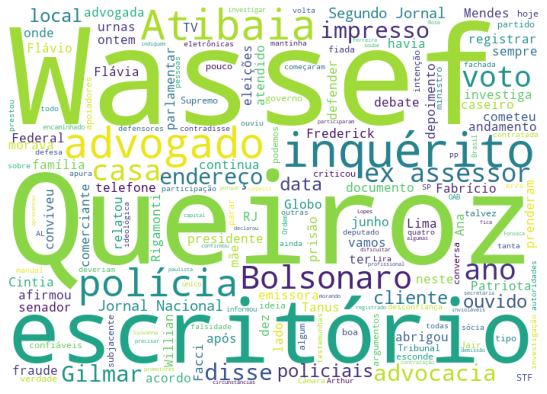

In [80]:
lista_novas_pessoas = []
corpus_novo = []
for noticia in novas_noticias:
    novas_dict = {}
    link = noticia[0]
    titulo = noticia[1]
    lista_sentencas = noticia[2]
  
    for sentenca in lista_sentencas:
        # NER
        lista_ent = reconhecer_entidades(sentenca)
        for ent in lista_ent:
            if ent[1] == 'PESSOA' and not ent[0] in todas_pessoas and not ent[0].startswith("##"):
                if ent[0] in novas_dict:
                    novas_dict[ent[0]] = novas_dict[ent[0]] + [(sentenca, lista_ent)]
                else:
                    novas_dict[ent[0]] = [(sentenca, lista_ent)]
      
    for p, lista_sent_ent in novas_dict.items():
        display(html_print("<b>NOVA PESSOA: </b>" + p))
        display(html_print("<b>Titulo da Noticia: </b>" + titulo + " - <a href='" + link + "'>[LINK]</a>"))
        display(html_print("<b>Citacoes no Texto: </b>"))

        # HIGHLIGHT
        texto_destacado = ""
        for sent, lista_ent in lista_sent_ent:
            texto_destacado += sent
            highlight_ent_verbo(sent, lista_ent, p)
        print("\n\n")

    corpus_novo.append(texto_destacado)
    lista_novas_pessoas.append(p)

# WORDCLOUD
wordcloud = WordCloud(width = 700, height = 500, background_color='white', stopwords=nltk.corpus.stopwords.words('portuguese')).generate(" ".join(corpus_novo))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud) 
plt.axis("off");

In [41]:
# Incluir NOVAS em base de todas
todas_noticias.extend([nova[0] for nova in novas_noticias]

todas_pessoas.extend(lista_novas_pessoas)

['https://noticias.uol.com.br/ultimas-noticias/agencia-estado/2021/07/30/se-pudesse-vetava-todo-o-fundao-repete-bolsonaro.htm']